In [47]:
import os
import numpy as np
import pandas as pd
import hvplot.pandas

In [48]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [49]:
atw_df = pd.read_csv('chris-ice_atw1.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
atw_df = atw_df.drop(columns= ["Open","High", "Low", "Wave", "Volume", "Prev. Day Open Interest", "EFP Volume", "EFS Volume", "Block Volume", "Change"])
atw_df.rename(columns={'Settle': "ATW Settle"}, inplace=True)
atw_df.head(10)

,ATW Settle
Date,
2021-01-08,68.50
2021-01-07,66.60
2021-01-06,64.25
2021-01-05,64.90
2021-01-04,69.30
2020-12-31,69.00
2020-12-30,69.40
2020-12-29,70.00
2020-12-28,71.65


In [50]:
ncf_df = pd.read_csv('chris-ice_ncf1.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
ncf_df = ncf_df.drop(columns= ["Open","High", "Low", "Wave", "Volume", "Prev. Day Open Interest", "EFP Volume", "EFS Volume", "Block Volume", "Change"])
ncf_df.rename(columns={'Settle': "NCF Settle"}, inplace=True)
ncf_df.head(10)

,NCF Settle
Date,
2021-01-07,81.05
2021-01-06,79.45
2021-01-05,80.35
2021-01-04,81.20
2020-12-31,80.50
2020-12-30,81.60
2020-12-29,84.20
2020-12-28,85.35
2020-12-24,84.50


In [51]:
df = pd.concat([atw_df, ncf_df], axis="columns", join = "inner")
df.head(10)

,ATW Settle,NCF Settle
Date,,
2021-01-07,66.60,81.05
2021-01-06,64.25,79.45
2021-01-05,64.90,80.35
2021-01-04,69.30,81.20
2020-12-31,69.00,80.50
2020-12-30,69.40,81.60
2020-12-29,70.00,84.20
2020-12-28,71.65,85.35
2020-12-24,69.75,84.50


In [52]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [79]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 0 is the 'atw' column
# Column index 1 is the `ncf` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [80]:
# Use 70% of the data for training and the remainder for testing
# YOUR CODE HERE!

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [81]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [82]:
# Reshape the features for the model
# YOUR CODE HERE!

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [93]:
# Build the LSTM model. 


model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))


In [94]:
# Compile the model


model.compile(optimizer="adam", loss="mean_squared_error")

In [95]:
# Summarize the model


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 30)             3840      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [105]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!

model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=1, verbose=1)

Epoch 1/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0038
Epoch 2/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0035
Epoch 3/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0035
Epoch 4/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0034
Epoch 5/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0033
Epoch 6/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 7/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 8/100
2163/2163 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 9/100
2163/2163 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 10/100
2163/2163 [==============================] - 3s 2ms/step - loss: 0.0030
Epoch 11/100
2163/2163 [==============================] - 3s 2ms/step - loss: 0.0031
Epoch 12/100
2163/2163 [==============================] - 3s 2ms/step - lo

In [106]:
# Evaluate the model
# YOUR CODE HERE!

model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 2ms/step - loss: 0.0449


0.04486384615302086

In [107]:
# Make some predictions
# YOUR CODE HERE!

predicted = model.predict(X_test)

In [108]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [109]:
# Create a DataFrame of Real and Predicted values
coal_futures = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices) :]) 
coal_futures.head()

,Real,Predicted
Date,,
2012-08-09,92.15,89.418427
2012-08-08,92.55,89.370148
2012-08-07,93.40,89.394318
2012-08-06,92.10,89.408791
2012-08-03,91.55,89.365303


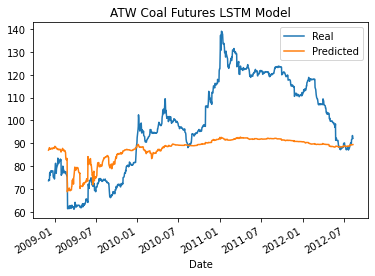

In [110]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
coal_futures.plot(title="ATW Coal Futures LSTM Model")